<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://www.univ-tlse3.fr/" ><img src="http://www.univ-tlse3.fr/medias/photo/ut3pres_logoq_1372757033342.jpg?ID_FICHE=49702" style="float:right; max-width: 250px; display: inline" alt="INSA"/></a> 
</center>

# Biais et Discrimination en Apprentissage Statistique
## Controverse sur le score de récidive aux USA:  equivant *vs.* Propublica 

### Résumé

## 1 Introduction

### 1.1 Données COMPAS
La méthodologie de Propublica pour le recueil des données est décrite dans un article de [Larson et al. (2016)](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/). Le jeu de données étudié est  disponible sur leur [site officiel](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/). En résumé, les investigateurs du site Propublica ont suivi une cohorte de plus de 7000 personnes libérées de prison dans un comté de Floride en recueillant certaines informations dont 
- le score de récidive calculé par le logiciel COMPAS, 
- la présence ou non d'une récidive deux ans après la date de libération.

### 1.2 Objectifs
 Une version simpifiée de l'analyse de Propublica est décrite ci-dessous afin de se focaliser sur les questions de biais et donc de discrimination potentielle. Le processus de sélection des données est celui de Propublica avant de procéder à une decription élémentaire pour ensuite étudier et caractériser différents types de biais: 
- estimation par intervalle de confiance de l'effet disproportionné sur les données réelles, 
- même estimation de l'effet pour le score de récidive (COMPAS) *High vs. low* calculé par *equivant*,
- puis sur le score prédit par une simple régression logistique,
- comparaison des erreurs de prévision, COMPAS et régression logistique, selon l'origine ethnique, 
- caractérisation de l'asymétrie des matrices de confusion à l'aide d'un intervalle de confiance.

C'est ce dernier point qui est à l'origine de la controverse entre *equivant* (Northpoint) et Propublica.

## 2 Prise en charge des données
### 2.1 Lecture

In [2]:
# Quelques librairies utiles
library(dplyr)
library(ggplot2)
library(grid)
library(gridExtra)
library(FactoMineR)
# Lecture des données
raw_data <- read.csv("./compas-scores-two-years.csv")
dim(raw_data)

[1] 7214   53

In [3]:
summary(raw_data)

       id                       name              first            last     
 Min.   :    1   anthony smith    :   3   michael    : 149   williams:  83  
 1st Qu.: 2735   angel santiago   :   2   christopher: 109   johnson :  76  
 Median : 5510   anthony gonzalez :   2   james      :  84   brown   :  68  
 Mean   : 5501   anthony louis    :   2   anthony    :  83   smith   :  65  
 3rd Qu.: 8246   brandon whitfield:   2   robert     :  76   jones   :  57  
 Max.   :11001   carlos vasquez   :   2   john       :  74   davis   :  46  
                 (Other)          :7201   (Other)    :6639   (Other) :6819  
 compas_screening_date     sex               dob            age       
 2013-02-20:  32       Female:1395   1987-02-04:   5   Min.   :18.00  
 2013-03-20:  32       Male  :5819   1987-12-21:   5   1st Qu.:25.00  
 2013-02-07:  31                     1989-04-27:   5   Median :31.00  
 2013-04-20:  30                     1989-08-31:   5   Mean   :34.82  
 2013-01-03:  29             

### 2.2 Préparation des données

Elimination de certaines lignes en suivant le processus de Propublica. 
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [4]:
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, score_text, sex, priors_count, 
        days_b_screening_arrest, decile_score, is_recid, two_year_recid, c_jail_in, c_jail_out,v_decile_score) %>% 
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>%
        filter(is_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(score_text != 'N/A')
dim(df)

[1] 6172   14

In [5]:
# renommer la variable "race"
colnames(df)[3]='origEthn'
summary(df)

      age        c_charge_degree             origEthn               age_cat    
 Min.   :18.00   F:3970          African-American:3175   25 - 45        :3532  
 1st Qu.:25.00   M:2202          Asian           :  31   Greater than 45:1293  
 Median :31.00                   Caucasian       :2103   Less than 25   :1347  
 Mean   :34.53                   Hispanic        : 509                         
 3rd Qu.:42.00                   Native American :  11                         
 Max.   :96.00                   Other           : 343                         
                                                                               
  score_text       sex        priors_count    days_b_screening_arrest
 High  :1144   Female:1175   Min.   : 0.000   Min.   :-30.00         
 Low   :3421   Male  :4997   1st Qu.: 0.000   1st Qu.: -1.00         
 Medium:1607                 Median : 1.000   Median : -1.00         
                             Mean   : 3.246   Mean   : -1.74         
          

In [6]:
str(df)

'data.frame':	6172 obs. of  14 variables:
 $ age                    : int  69 34 24 44 41 43 39 27 23 37 ...
 $ c_charge_degree        : Factor w/ 2 levels "F","M": 1 1 1 2 1 1 2 1 2 2 ...
 $ origEthn               : Factor w/ 6 levels "African-American",..: 6 1 1 6 3 6 3 3 1 3 ...
 $ age_cat                : Factor w/ 3 levels "25 - 45","Greater than 45",..: 2 1 3 1 1 1 1 1 3 1 ...
 $ score_text             : Factor w/ 3 levels "High","Low","Medium": 2 2 2 2 3 2 2 2 3 2 ...
 $ sex                    : Factor w/ 2 levels "Female","Male": 2 2 2 2 2 2 1 2 2 1 ...
 $ priors_count           : int  0 0 4 0 14 3 0 0 3 0 ...
 $ days_b_screening_arrest: int  -1 -1 -1 0 -1 -1 -1 -1 0 0 ...
 $ decile_score           : int  1 3 4 1 6 4 1 4 6 1 ...
 $ is_recid               : int  0 1 1 0 1 0 0 0 1 0 ...
 $ two_year_recid         : int  0 1 1 0 1 0 0 0 1 0 ...
 $ c_jail_in              : Factor w/ 6908 levels "","2013-01-01 01:31:55",..: 3032 454 1838 4434 5450 3273 5707 4391 3735 4 ...
 $ c_jail_

## 3 Exploration statistique

### 3.1 Description Univariée

Représentation des distributions des différentes variables.

#### Variables quantitatives

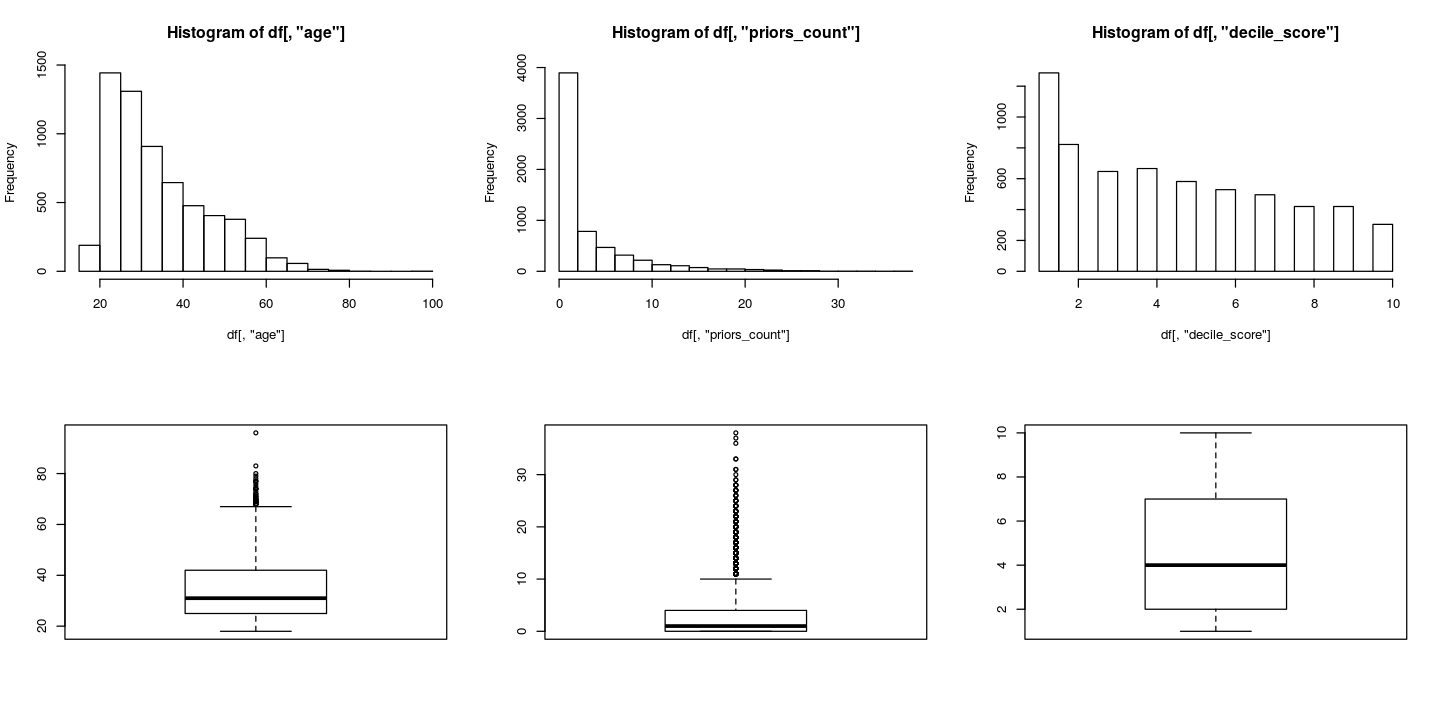

In [7]:
par(mfrow=c(2,3))
options(repr.plot.width=12, repr.plot.height=6)
hist(df[,'age']); hist(df[,'priors_count']); hist(df[,'decile_score'])
boxplot(df[,'age']); boxplot(df[,'priors_count']); boxplot(df[,'decile_score'])

Des distributions ne sont pas symmétriques mais, pour rester cohérent avec l'analyse de Propublica aucune transformation n'est appliquée sur ces variables.
#### Variables qualitatives

In [8]:
df$two_year_recid=as.factor(df$two_year_recid)
df$is_recid=as.factor(df$is_recid)
two_year_recid=ggplot(data=df, aes(x=two_year_recid))+geom_bar(width=0.2)
is_recid=ggplot(data=df, aes(x=is_recid))+geom_bar(width=0.2)
origEthn=ggplot(data=df, aes(x=origEthn))+geom_bar(width=0.2)
age_cat=ggplot(data=df, aes(x=age_cat))+geom_bar(width=0.2)
sex=ggplot(data=df, aes(x=sex))+geom_bar(width=0.2)
c_charge_degree=ggplot(data=df, aes(x=c_charge_degree))+geom_bar(width=0.2)
score_text=ggplot(data=df, aes(x=score_text))+geom_bar(width=0.2)

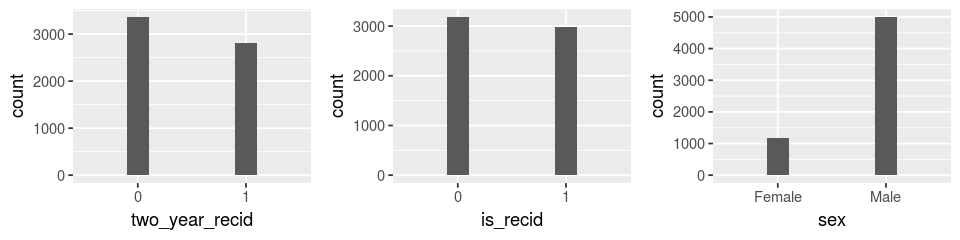

In [9]:
options(repr.plot.width=8,repr.plot.height=2)
grid.arrange(two_year_recid,is_recid,sex,nrow=1)

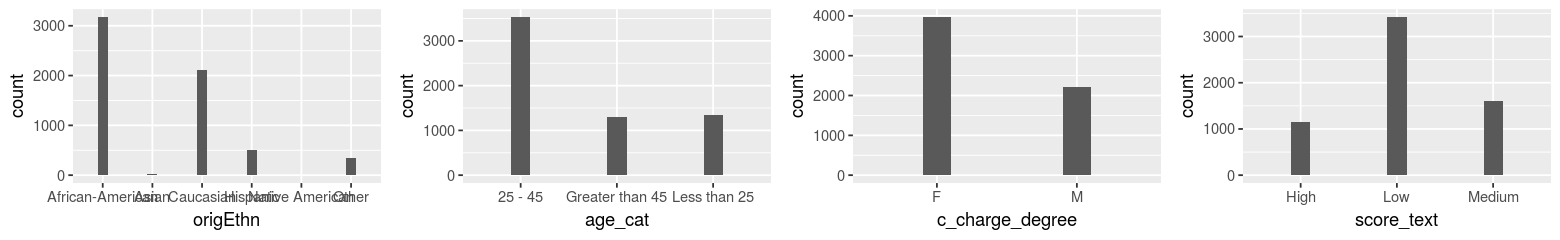

In [10]:
options(repr.plot.width=13,repr.plot.height=2)
grid.arrange(origEthn,age_cat,c_charge_degree,score_text,nrow=1)

La répartition des origines ethniques sont déséquilibrées; seules deux classes sont ensuite considées
- `African-American`
- `Caucasian`

en laissant de côté les origines hispaniques, asiatiques, amérindiennes et autres.


In [11]:
df_f=droplevels(df[df$origEthn =="Caucasian" | df$origEthn =="African-American",])
summary(df_f)

      age        c_charge_degree             origEthn               age_cat    
 Min.   :18.00   F:3440          African-American:3175   25 - 45        :3026  
 1st Qu.:25.00   M:1838          Caucasian       :2103   Greater than 45:1096  
 Median :31.00                                           Less than 25   :1156  
 Mean   :34.45                                                                 
 3rd Qu.:42.00                                                                 
 Max.   :80.00                                                                 
                                                                               
  score_text       sex        priors_count    days_b_screening_arrest
 High  :1068   Female:1031   Min.   : 0.000   Min.   :-30.00         
 Low   :2753   Male  :4247   1st Qu.: 0.000   1st Qu.: -1.00         
 Medium:1457                 Median : 2.000   Median : -1.00         
                             Mean   : 3.462   Mean   : -1.73         
          

### 3.2 Description bivariée
#### *Mosaic plots*
Les variables `two_year_recid`  et `is_recid` sont redondantes; utiliser l'une ou l'autre ne change pas fondamentalement les résultats.

In [12]:
table(df_f$is_recid,df_f$two_year_recid)

   
       0    1
  0 2631    0
  1  164 2483

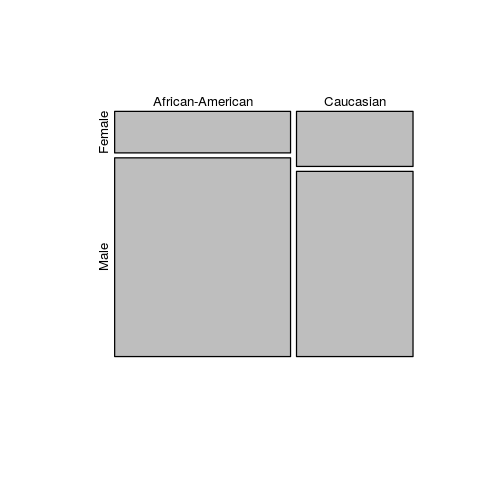

In [13]:
options(repr.plot.width=4,repr.plot.height=4)
mosaicplot(table(df_f$origEthn,df_f$sex),main="")

Les femmes sont bien moins nombreuses et aussi proportionnellement moins présentes parmis les afro-américaines.

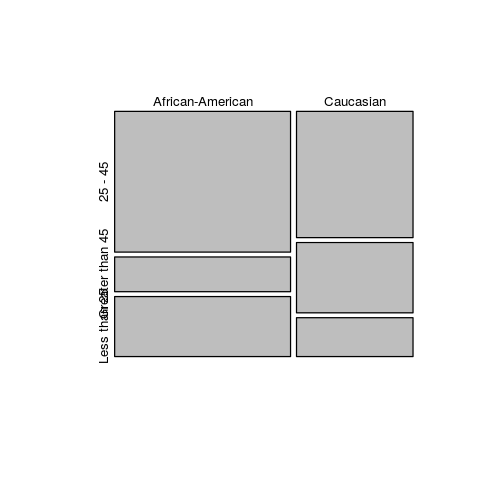

In [14]:
mosaicplot(table(df_f$origEthn,df_f$age_cat),main="")

Il y'a  proportionnellement plus de jeunes parmi les afro-américains.

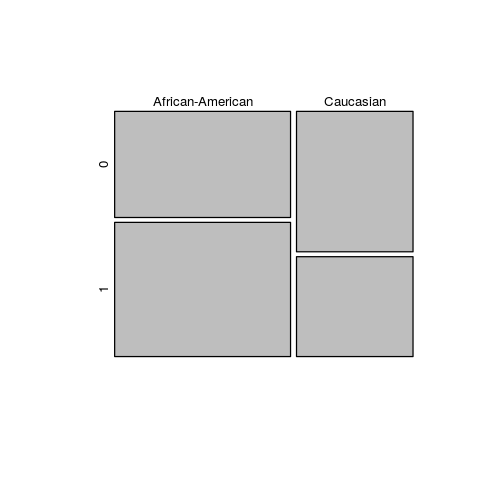

In [15]:
mosaicplot(table(df_f$origEthn,df_f$is_recid),main="")

et aussi proportionnellement plus de récidivistes. C'est un biais social connu et une information importante à retenir pour la suite.

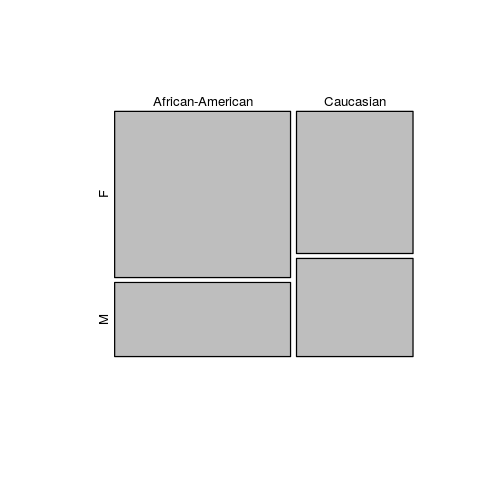

In [16]:
mosaicplot(table(df_f$origEthn,df_f$c_charge_degree),main="")

Même interprétation que précédemment cette fois sur le degré de l'infraction commise qui peut être élevé (F) ou faible(M).

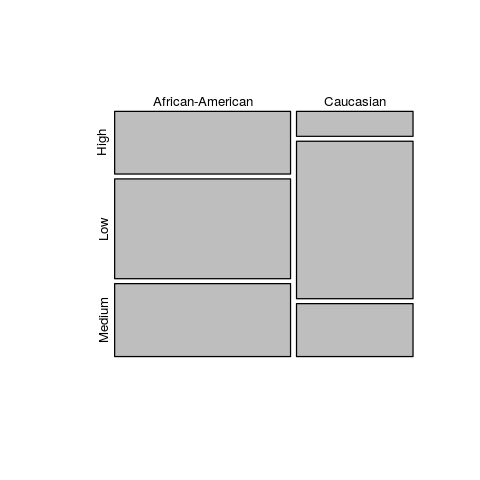

In [17]:
options(repr.plot.width=4,repr.plot.height=4)
mosaicplot(table(df_f$origEthn,df_f$score_text),main='')

De façon analogue, les afro-américains sont proportionnellement beaucoup plus associés à un score élevé (High) de récidive.


### 3.3 Description Multivariée

Une [Analyse Factorielle des Corresponsances Multiples](http://wikistat.fr/pdf/st-m-explo-afcm.pdf) est adaptée à la représentation des modalités de variables qualitatives.

In [18]:
df_quali=subset(df_f,select=c('is_recid','sex','origEthn','age_cat','c_charge_degree','score_text'))
afcm=MCA(df_quali,graph=FALSE)

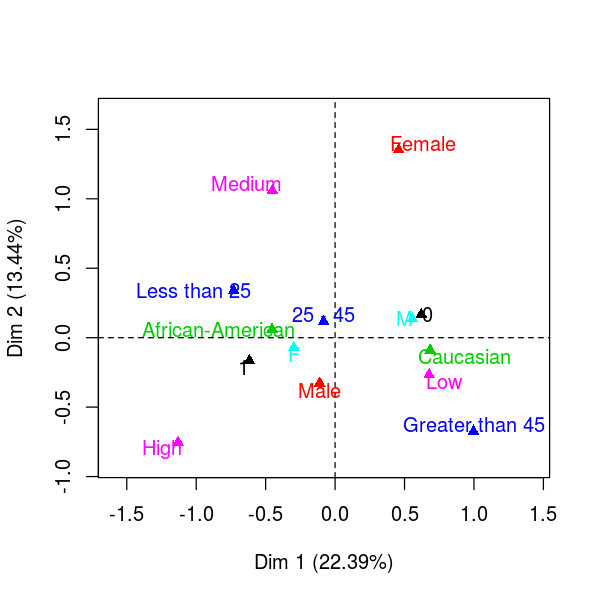

In [19]:
options(repr.plot.width=5, repr.plot.height=5)
plot.MCA(afcm,invisible='ind',habillage="quali", title="")

Ce graphique représente assez simplement les correspondances entre les modalités et donc globalement les liens entre les variables. La non récidive (à droite) concerne particulièrement les personnes plus agées, de sexe plutôt féminin, d'origine caucasienne avec un faible score COMPAS. Attention, cette analyse élémentaire ne prend pas en compte d'éventuelles interactions de niveau plus important que 2 entre les variables.

### 3.4 Simplification des données
Dans tous ce qui suit, la variable `score_text` est recodée en deux modalités:
- 1 = `low` (la classe favorable),
- 0 = `high` et `medium`;

de même que la variable `two_year_recid`.

*NB* Les codes des classes 0 et 1 sont échangées par rapport aux notations de Propublica dans un souci d'uniformisation par rapport aux méthodes implémentées par la suite: `1` code la situation la plus "favorable" c'est-à-dire un faible score de récidive d'une part, une absence de récidive d'autre part.

In [20]:
score_bin=as.factor(ifelse(df_f$score_text=='Low',1,0))
two_year_recid_bin=as.factor(ifelse(df_f$two_year_recid=='1',0,1))
df_t=data.frame(df_f,score_bin,two_year_recid_bin)
summary(df_t)

      age        c_charge_degree             origEthn               age_cat    
 Min.   :18.00   F:3440          African-American:3175   25 - 45        :3026  
 1st Qu.:25.00   M:1838          Caucasian       :2103   Greater than 45:1096  
 Median :31.00                                           Less than 25   :1156  
 Mean   :34.45                                                                 
 3rd Qu.:42.00                                                                 
 Max.   :80.00                                                                 
                                                                               
  score_text       sex        priors_count    days_b_screening_arrest
 High  :1068   Female:1031   Min.   : 0.000   Min.   :-30.00         
 Low   :2753   Male  :4247   1st Qu.: 0.000   1st Qu.: -1.00         
 Medium:1457                 Median : 2.000   Median : -1.00         
                             Mean   : 3.462   Mean   : -1.73         
          

In [21]:
table(df_f$two_year_recid,df_f$is_recid)

   
       0    1
  0 2631  164
  1    0 2483

## 4 Biais et discriminations
Différents critères de biais ou discrimination sont évalués; trois niveaux sont successivement considérés.

1. L'effet disproportionné (*disparate impact*) est couramment utilisés pour détecter aux USA une discrimination indirecte ou implicite ou envers un groupe pour l'accès à l'emploi ou un logement. Il est estimé par intervalle de confiance (Besse et al. 2008) en fonction des répartitions par origine des
    - récidives afin de mettre en évidence des biais déjà présents dans les données, 
    - prévisions de récidive issues du score Compas afin d'évaluer si la prévision répercute ou renforce ce biais.
2. La comparaison des erreurs de prévision conditionnellement à l'origine etnique. 
3. Enfin, selon la démarche de Propublica, c'est l'asymétrie des matrices de confusion selon l'origine ethnique qui est étudiée.

### 4.1 *Disparate Impact* ou effet disproportionné

Deux niveaux de mesures de discrimination sont considérées. Le premier  est calculé à l'aide du *DI* sur les données d'apprentissage afin d'évaluer le biais déjà présent dans ces données. Le deuxième mesure l'impact d'un modèle sur ce biais toulours à l'aide du $DI$.

#### Notations 

- $Y$ est la variable cible ou à expliquer, ici le revenu, $Y=1$ revenu élevé *vs* $Y=0$; 
- $g(X)=\hat{Y}$ le score élevé ou faible ou prévision du revenu, $g(X)=\hat{Y}=0$: prévision d'un revenu faible;
- $S$ est la variable sensible qui désigne le groupe en principe protégé par la loi contre une possible discrimination. Il s'agit ici du genre ou de l'origine ethnique réduite à 2 modalités: caucasien ($S=1$) ou non caucasien ($S=0$). 

L'effet disproportionné mesure une situation de biais de société déjà présent dans la base de données. 
$$DI=\frac{P(Y=1|S=0)}{P(Y=1|S=1)}.$$
Il est estimé à partir des valeurs de la table de contingence croisant les variables $Y$ et $S$ par le rapport:
$$\frac{n_{21}}{(n_{11}+n_{21})}/\frac{n_{22}}{(n_{12}+n_{22})}.$$

Appliqué à la prévision $g(X)=\hat{Y}$ de la variable cible $Y$, il mesure le biais de cette prévision et donc le risque de discrimination opéré par la prévision.

#### Fonction *disparate*
Une fonction R calcule le $DI$ et fournit de plus une estimation par intervalle de confiance (Besse et al. 2018) décomposant la fonction de densité de la statistique de test par la *delta method*. Cette fonction a quatre arguments:   
- une matrice $X$ de valeurs binaires $(0,1)$;
- l'indice de la variable $S$  de $X$ considérée comme sensible; 
- l'indice de la variable cible $Y$ ou de sa prévision $g(X)=\hat{Y}$;
- le risque de l'intervalle de confiance, par défaut 5%.

Elle renvoie les trois estimations $DI$ et $IC_g$, $IC_d$ bornes de l'intervalle de confiance.

Cette fonction estime aussi, la cas échéant, le *BER* (*Balanced Error Rate*):
$$BER=\frac{P(\hat{Y}=0|S=1)+P(\hat{Y}=1|S=0)}{2}.$$

#### Recodage des données
La fonction `disparate` nécessite de mettre en forme les variables utilisées; par principe, "1" code la modalité plus "favorable": origine caucasienne, pas de récidive, score faible et, suivant Propublica, le score de récidive est considéré élevé lorsqu'il est plus grand que 4.

In [26]:
# Construction du data frame
S= as.integer(df_t$origEthn)-1
Y=2-as.integer(df_t$is_recid)
Ycompas=1-as.integer(df_t$decile_score>4)
coded_data=data.frame(S,Ycompas,Y)
cbind(coded_data,df_t[,c("origEthn","decile_score","two_year_recid")])[5:10,]

,S,Ycompas,Y,origEthn,decile_score,two_year_recid
8,1,1,1,Caucasian,4,0
9,0,0,0,African-American,6,1
10,1,1,1,Caucasian,1,0
11,0,1,1,African-American,4,0
12,1,1,0,Caucasian,1,1
13,0,1,0,African-American,3,1


In [27]:
table(coded_data$Y,coded_data$S)

   
       0    1
  0 1773  874
  1 1402 1229

#### $DI$ estimé sur la base d'apprentissage 
Estimation ponctuelle du $DI$ pour déterminer le biais sociale de la variable observée $Y$ de récidive.

In [28]:
DI=function(table){round((table[2,1]/(table[1,1]+table[2,1]))/(table[2,2]/(table[1,2]+table[2,2])),2)}
DI(table(coded_data$Y,coded_data$S))

[1] 0.76

Estimation par intervalle de confiance.

In [29]:
source('../Functions/disparate.R')
round(disparate(coded_data,1,3),2)[1:3]

[1] 0.72 0.76 0.80

Il y a proportionnellement plus de récidives pour une origine afro-américaine mais sans que celle-ci soit disproportionnée car $0.8 \in DI$

#### $DI$ sur la base du score COMPAS
Estimation ponctuelle.

In [30]:
DI(table(coded_data$Ycompas,coded_data$S))

[1] 0.63

Estimation par intervalle de confiance.

In [31]:
round(disparate(coded_data,1,2),2)[1:3]

[1] 0.60 0.63 0.67

Le score Compas renforce significativement le caractère discriminatoire car les intervalles sont disjoints. C'est contradictoire sur cet exemple avec les affirmation d'*equivant* qui affirme que les score se distribuent de façon identique selon l'origine ethnique.

### 4.2 Taux d'erreur selon l'origine
L'estimation du taux d'erreur induit par le score Compas peut être calculée avec l'ensemble des données car le modèle sous-jacent a été estimé sur d'autres données.

In [32]:
tauxErr=function(table){round((table[1,2]+table[2,1])/sum(table)*100,1)}

In [33]:
tauxErr(table(df_t$decile_score>4,df_t$is_recid==1))

[1] 34.4

On trouve comme attendu un taux d'erreur important de 34% qui est ventilé selon l'origine:

In [34]:
apply(table(df_t$decile_score>4,df_t$is_recid==1,df_t$origEthn),3,tauxErr)

African-American        Caucasian 
            34.8             33.8

*Question*: ces taux d'erreur sont-ils significativement différents? Estimation d'intervalles de confiance par delta method? par bootstrap ? par validation croisée généralisée?

En principe *equivant* affirme que ces taux sont similaires pour qu'il n'y ait pas discrimination; cela semble peu probant sur ces données.

*Remarque*: le critère de *overall accuracy equality* est obtenu en calculant 1- ces taux d'erreur.

### 4.3 Asymétrie des matrices de confusion
Une troisième source de discrimination concerne une inversion de l'asymétrie de la matrice de confusion selon la variable sensible, notamment les taux de faux positifs ou faux négatifs selon l'origine.

De très nombreux critères ont été proposés pour évaluer cette asymétrie et dont [Verma et Rubin 2018](http://fairware.cs.umass.edu/papers/Verma.pdf)) proposent une synthèse. Leur définitions sont basées sur les différentes fréquences issues de la table de contingence et calculées par la fonction ci-dessous.

In [35]:
contRatio <- function(T){ 
    # Ratios calculés à partir de la matrice de confusion
    TP=T[2,2] # true positive
    FP=T[1,2] # false positive
    FN=T[2,1] # false negative
    TN=T[1,1]  # true negative
    PPV=TP/(TP+FP) # P(Y=1|g(x)=1) positive predictive value
    FDR=FP/(TP+FP) # P(Y=0|g(x)=1) false discovery rate 
    FOR=FN/(TN+FN) # P(Y=1|g(x)=0) false omission rate
    NPV=TN/(TN+FN) # P(Y=0|g(x)=0) negative predictive value
    TPR=TP/(TP+FN) # P(g(x)=1|Y=1) true positive rate
    FPR=FP/(FP+TN) # P(g(x)=1|Y=0) false positive rate
    FNR=FN/(TP+FN) # P(g(x)=0|Y=1) false negative rate
    TNR=TN/(FP+TN) # P(g(x)=0|Y=0) true negative rate
    return(list("PPV"=PPV,"FDR"=FDR,"FOR"=FOR,"NPV"=NPV,"TPR"=TPR,"FPR"=FPR,"FNR"=FNR,"TNR"=TNR))
}

In [36]:
contRatio(table(coded_data$Ycompas,coded_data$Y))

$PPV
[1] 0.6780692

$FDR
[1] 0.3219308

$FOR
[1] 0.3660748

$NPV
[1] 0.6339252

$TPR
[1] 0.6480203

$FPR
[1] 0.3354455

$FNR
[1] 0.3519797

$TNR
[1] 0.6645545

Liste de critères de loyauté pouvant être définis à partir des fréquences précédentes conditionnellement à la variable sensible. Selon les auteurs, il y a loyauté de traitement si:
- *Predictive parity*: les deux groupes ont les mêmes *PPV*s et par conséquence les mêmes *FDR*s;
- *False positive error rate balance* ou *predictive equality*: mêmes *FPR*s et par conséquence les mêmes *TNR*s;
- *False negative error rate balance* ou *equal opportunity*: mêmes *FNR*s et par conséquence les mêmes *TPR*s;
- *Conditional procedure accuracy equality* ou *disparate mistreatment* ou *equalized odds* combine les deux ci-dessus: mêmes *TPR*s **ET** mêmes *FPR*s;
- *Conditionnal use accuracy equality*: mêmes *PPV*s **ET** mêmes *NPV*s;
- *Teatment equality*: les rapports *FN/FP* sont les mêmes pour les deux groupes.

D'autres critères ont été proposés (cf. Verma et Rubin; 2018), il ne sont pas développés ici.

La matrice de confusion est calculée conditionnellement à l'origine.

In [37]:
fairness=data.frame("AfroAmericain"=as.matrix(contRatio(table(coded_data$Ycompas,coded_data$Y,coded_data$S)[,,1])),
                    "Caucasien"=as.matrix(contRatio(table(coded_data$Ycompas,coded_data$Y,coded_data$S)[,,2])))
fairness

,AfroAmericain,Caucasien
PPV,0.585592,0.7835639
FDR,0.414408,0.2164361
FOR,0.2961083,0.5080092
NPV,0.7038917,0.4919908
TPR,0.6099554,0.684435
FPR,0.3176599,0.3821839
FNR,0.3900446,0.315565
TNR,0.6823401,0.6178161


Il n'est pas simple de comparer toutes ces quantités. Il apparaît néanmoins que les taux de faux positifs (*Conditional procedure accuracy equality*) sont en faveur des caucasiens et les taux de faux négatifs aux détriment ds afro-américains. Cette asymétrie inversée des matrice de confusion est à l'origine de la controverse publiée par Propublica dénonçant le racisme du score COMPAS.

#### Estimation par intervalle de confiance de OAE
La comparaison des taux de faux positifs (resp. négatifs) peut être précisée en estimant leur rapport par un intervalle de confiance. C'est l'objet de la fonction `OverallAccuracyEquality` qui admet 5 paramètres:
- X: matrice X de caleurs binaires
- S: index de la variable du groupe protégé
- Y: index de la variable cible
- P: index de la prévision $\hat{Y}$

In [38]:
source('../Functions/OverallAccuracyEquality.R')
summary(coded_data)

       S             Ycompas             Y         
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.0000   Median :1.0000   Median :0.0000  
 Mean   :0.3984   Mean   :0.5216   Mean   :0.4985  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  

In [39]:
OAE(coded_data,1,3,2,alpha=0.05)

,inf,est_value,sup
TP,0.7077817,0.7473443,0.7869069
TN,1.3250824,1.4307008,1.5363192


In [40]:
0.3176599/0.3821839; 0.3900446/0.315565

[1] 0.8311703

[1] 1.23602

Résultats proches mais pas identiques... et assez différents de ceux du manuscripts; En revanche, les estimations des DI sont cohérentes. Chercher l'erreur...

## 5 Prévision de la récidive
Cette section est consacrée à la comparaison de deux scores de récidive. Celui COMPAS fournit par la société *equivant* et celui obtenu à partir d'un simple modèle de régression logistique. Bien d'autres algorithmes de prévision auraient pu être testés mais ce n'est pas le principal objectif.

### 5.1 Qualité du score COMPAS

#### Echantillon test
Pour rendre possible les comparaisons, les erreurs sont estimées sur le même échantillon test qui sera indépendant de l'échantillon d'apprentissage utilisé pour la régression logistique.

In [41]:
npop=nrow(df_t)
# tirage de 1000 indices sans remise
set.seed(11)
testi=sample(1:npop,1000)
#Liste des indices restant qui n’ont pas été tirés
appri=setdiff(1:npop,testi)
# Extraction échantillons d’apprentissage
dataApp=df_t[appri,]
# Echantillon test
dataTest=df_t[testi,]

#### Taux d'erreur du score COMPAS
Le seuil de score COMPAS de "4" est celui généralement retenu pour prévoir une récidive.

In [42]:
conf=table(dataTest$decile_score>4,dataTest$is_recid==1)
conf;tauxErr(conf)

       
        FALSE TRUE
  FALSE   334  188
  TRUE    161  317

[1] 34.9

Taux d'erreur très élevé comme attendu et légèrement différent de celui estimé sur toutes les données. Il dépend de l'échantillon qui a été tiré et donc de l'initialisation du génératoire de nombres aléatoires.

### 5.3 Qualité prédictive d'une régression logistique
Dans son étude, Problica propose l'estimation d'un modèle de régression logistique expliquant la variable `score_text` en fonction des variables: origine Ethnique, âge, *criminal history*, *future recidivism*, *charge degree*, genre, afin d'évaluer les influences de ces variables sur le score COMPAS. Propublica propose également de mettre en évidence l'effet des interactions avec la variable `age`. 

La régression logistique est utilisée ci-dessous avec un objectif plutôt prédictif. La récidive peut elle être prédite en fonction des quelques caractéristiques connues des individus? Cette prévision est-elle meilleure ou tout du moins aussi mauvaise que celle fournie par le score COMPAS produit par la société *equivant*?
#### Estimation du modèle

In [43]:
model_logit <- glm(is_recid ~ sex+origEthn+age+age_cat+priors_count+
                   +c_charge_degree,family=binomial(link='logit'), data=dataApp)
summary(model_logit)


Call:
glm(formula = is_recid ~ sex + origEthn + age + age_cat + priors_count + 
    +c_charge_degree, family = binomial(link = "logit"), data = dataApp)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7043  -1.0309   0.1324   1.0372   2.2348  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             0.787683   0.232408   3.389 0.000701 ***
sexMale                 0.424154   0.085287   4.973 6.58e-07 ***
origEthnCaucasian      -0.140859   0.070562  -1.996 0.045909 *  
age                    -0.049838   0.006732  -7.403 1.33e-13 ***
age_catGreater than 45  0.374607   0.164744   2.274 0.022974 *  
age_catLess than 25     0.216568   0.105955   2.044 0.040957 *  
priors_count            0.177610   0.010082  17.616  < 2e-16 ***
c_charge_degreeM       -0.147132   0.070981  -2.073 0.038188 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Nu

#### Taux d'erreur

In [44]:
pihat<-predict(model_logit,newdata=dataTest)
tauxErr(table(pihat>0.5,dataTest$is_recid))

[1] 36

### 5.4 Même chose avec une forêt aléatoire 

In [45]:
library(randomForest)
model_rf <- randomForest(is_recid ~ sex+origEthn+age+age_cat+priors_count+
                   +c_charge_degree, data=dataApp)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:gridExtra’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine



In [46]:
predRec<-predict(model_rf,newdata=dataTest)
tauxErr(table(predRec,dataTest$two_year_recid))

[1] 32.8

*Remarques:*
- Sur l'échantillon test considéré, 
- Limitation: ce modèle ne s'applique qu'à des détenus libérés ou libérables, pas à des individus jamais condamnés.
- Conditionnellement à la présence des autres variables, l'origine ethnique n'est pas significative dans le modèle.
- Le taux d'erreur de ce modèles  de prévision faisant intervenir la gravité du crime précédent et le nombre d'incarcération est aussi mauvais que celui issu du score COMPAS. On retrouve bien le type de résultats de Dressel et Farid (2018); l'algorithme *random forest* fait bien mieux que la régression logistique et mieux que le score COMPAS.
- Une itération des estimations de ces erreurs par validation croisée *Monte Carlo* donnerait une indication sur leur distribution. 

### Conclusion
Biaisé donc discriminatoire à bien des points de vue sur cet exemple de données et présentant une aussi mauvaise qualité prédictive qu'un modèle de régression logistique rudimentaire, le score COMPAS est à éviter.

### Références
